Can we back into the same adversary prediction abilities using only the sorted edge weights? I.e. if we just look at the top n edges in the filtration, is this good enough? Or do we actually use persistent homology effectively?

In [1]:
import os
import parse
import pickle
import copy
import math

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import dionysus as dion
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming, cosine
from sklearn import svm
from sklearn.model_selection import cross_val_score
import sklearn
import networkx as nx
import seaborn as sns

PERCENTILE = 95

from pt_activation.models.ccff_sigmoid import CCFF

%load_ext autoreload
%autoreload 2

In [2]:
COLORS = ['#12355b', '#ff6978']
EDGE_COLOR = '#272d2d'
PLT_LABELS = ['Unaltered', 'Adversarial']

In [3]:
def get_adv_info(filename):
    format_string = 'true-{}_adv-{}_sample-{}.npy'
    parsed = parse.parse(format_string, filename)
    return {'true class':int(parsed[0]), 'adv class':int(parsed[1]), 'sample':int(parsed[2])}

def read_adversaries(loc):
    ret = []
    for f in os.listdir(loc):
        if os.path.isfile(os.path.join(loc,f)) and f.find('.npy') != -1:
            adv = np.load(os.path.join(loc, f))
            info = get_adv_info(f)
            info['adversary'] = adv
            ret.append(info)
    return ret
    

In [4]:
adv_directory_loc = '/home/tgebhart/projects/pt_activation/logdir/adversaries/mnist/projected_gradient_descent/ccff_sigmoid.pt'
adversaries = read_adversaries(adv_directory_loc)
adversaries = sorted(adversaries,  key=lambda k: k['sample'])

In [5]:
def create_sample_graph(f,tnms,wm):

    subgraphs = {}
    m = dion.homology_persistence(f)
    dgm = dion.init_diagrams(m,f)[0]
    for i,c in enumerate(m):
        if len(c) == 2:
            w = f[i].data
            if (tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]) in wm:
                w = wm[(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]])]
            elif (tnms[f[c[1].index][0]],tnms[f[c[0].index][0]]) in wm:
                w = wm[(tnms[f[c[1].index][0]],tnms[f[c[0].index][0]])]
#                 else:
#                     print((tnms[f[c[0].index][0]],tnms[f[c[1].index][0]]))
#                     raise Exception('NO WM!')
            if False: #tnms[f[c[0].index][0]] in subgraphs:
                subgraphs[tnms[f[c[0].index][0]]].add_edge(tnms[f[c[0].index][0]],tnms[f[c[1].index][0]], weight=w)
            else:
                eaten = False
                for k, v in subgraphs.items():
                    if v.has_node(tnms[f[c[0].index][0]]):
                        if tnms[f[c[1].index][0]] in subgraphs:
                            v.add_node(tnms[f[c[1].index][0]])
#                                 subgraphs[k] = nx.union(v, subgraphs[tnms[f[c[1].index][0]]])
                        else:
                            v.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                        eaten = True
                        break
                if not eaten:
                    g = nx.Graph()
                    g.add_edge(tnms[f[c[0].index][0]], tnms[f[c[1].index][0]], weight=w)
                    subgraphs[tnms[f[c[0].index][0]]] = g

    return subgraphs, dgm, create_lifetimes(f,subgraphs,dgm,tnms)

def create_lifetimes(f, subgraphs, dgm, ids):
    lifetimes = {}
    for pt in dgm:
        k = ids[f[pt.data][0]]
        if k in subgraphs.keys():
            if pt.death < float('inf'):
                lifetimes[k] = pt.birth - pt.death
            else:
                lifetimes[k] = pt.birth
    return lifetimes



# In[9]:


def create_subgraphs(model, batch_size, up_to):
    device = torch.device("cpu")
    kwargs = {'num_workers': 1, 'pin_memory': True}
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../../data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),
                               ])), batch_size=batch_size, shuffle=False, **kwargs)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += batch_size
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes


def create_adversary_subgraphs(model, batch_size, up_to, adversaries):
    device = torch.device("cpu")
    adv_images = torch.tensor(np.array([a['adversary'] for a in adversaries]))
    adv_labels = torch.tensor(np.array([a['true class'] for a in adversaries]))
    adv_samples = [a['sample'] for a in adversaries]

    print(adv_images.shape, adv_labels.shape)

    advs = torch.utils.data.TensorDataset(adv_images, adv_labels)
    test_loader = torch.utils.data.DataLoader(advs, batch_size=batch_size, shuffle=False)

    model.eval()
    test_loss = 0
    correct = 0
    t = 0
    res_df = []
    subgraphs = []
    diagrams = []
    lifetimes = []
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, hiddens = model(data, hiddens=True)
            test_loss = F.nll_loss(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            for s in range(data.shape[0]):
                this_hiddens = [hiddens[i][s] for i in range(len(hiddens))]
                print('Filtration: {}'.format(s+t))
                f, nm, wm = model.compute_dynamic_filtration2(data[s], this_hiddens, percentile=PERCENTILE, return_nm=True, absolute_value=True)
                tnm = {v: k for k, v in nm.items()}
                sg, dg, lifetime = create_sample_graph(f, tnm, wm)
                row = {'loss':test_loss, 'class':target.cpu().numpy()[s], 'prediction':pred.cpu().numpy()[s][0]}
                res_df.append(row)
                subgraphs.append(sg)
                diagrams.append(dg)
                lifetimes.append(lifetime)

            t += (batch_size)
            if t >= up_to:
                break

    return pd.DataFrame(res_df), subgraphs, diagrams, lifetimes

In [6]:
model_location = '/home/tgebhart/projects/pt_activation/logdir/models/mnist/ccff_sigmoid.pt'
model = CCFF()
model.load_state_dict(torch.load(model_location))

In [7]:
res_df, sample_graphs, dgms, lifetimes = create_subgraphs(model, 1, 1000)

Filtration: 0
filtration size 62198
Filtration: 1
filtration size 62422
Filtration: 2
filtration size 61952
Filtration: 3
filtration size 62557
Filtration: 4
filtration size 62357
Filtration: 5
filtration size 61997
Filtration: 6
filtration size 62408
Filtration: 7
filtration size 62222
Filtration: 8
filtration size 62531
Filtration: 9
filtration size 62399
Filtration: 10
filtration size 62607
Filtration: 11
filtration size 62548
Filtration: 12
filtration size 62234
Filtration: 13
filtration size 62525
Filtration: 14
filtration size 61967
Filtration: 15
filtration size 62578
Filtration: 16
filtration size 62378
Filtration: 17
filtration size 62279
Filtration: 18
filtration size 62650
Filtration: 19
filtration size 62219
Filtration: 20
filtration size 62321
Filtration: 21
filtration size 62263
Filtration: 22
filtration size 62404
Filtration: 23
filtration size 62393
Filtration: 24
filtration size 62282
Filtration: 25
filtration size 62807
Filtration: 26
filtration size 62120
Filtration:

Filtration: 219
filtration size 62537
Filtration: 220
filtration size 62306
Filtration: 221
filtration size 62554
Filtration: 222
filtration size 62657
Filtration: 223
filtration size 62270
Filtration: 224
filtration size 61931
Filtration: 225
filtration size 62640
Filtration: 226
filtration size 62477
Filtration: 227
filtration size 62153
Filtration: 228
filtration size 61979
Filtration: 229
filtration size 62045
Filtration: 230
filtration size 62336
Filtration: 231
filtration size 62316
Filtration: 232
filtration size 62422
Filtration: 233
filtration size 62387
Filtration: 234
filtration size 62087
Filtration: 235
filtration size 62270
Filtration: 236
filtration size 62285
Filtration: 237
filtration size 62260
Filtration: 238
filtration size 62366
Filtration: 239
filtration size 61922
Filtration: 240
filtration size 62426
Filtration: 241
filtration size 62525
Filtration: 242
filtration size 62441
Filtration: 243
filtration size 62315
Filtration: 244
filtration size 62182
Filtration: 

Filtration: 435
filtration size 62249
Filtration: 436
filtration size 62306
Filtration: 437
filtration size 62732
Filtration: 438
filtration size 62210
Filtration: 439
filtration size 62267
Filtration: 440
filtration size 62825
Filtration: 441
filtration size 62477
Filtration: 442
filtration size 62444
Filtration: 443
filtration size 62231
Filtration: 444
filtration size 62534
Filtration: 445
filtration size 62474
Filtration: 446
filtration size 62543
Filtration: 447
filtration size 62351
Filtration: 448
filtration size 62333
Filtration: 449
filtration size 62699
Filtration: 450
filtration size 62414
Filtration: 451
filtration size 62516
Filtration: 452
filtration size 62393
Filtration: 453
filtration size 62755
Filtration: 454
filtration size 62300
Filtration: 455
filtration size 62009
Filtration: 456
filtration size 62336
Filtration: 457
filtration size 62387
Filtration: 458
filtration size 62366
Filtration: 459
filtration size 62485
Filtration: 460
filtration size 62186
Filtration: 

Filtration: 651
filtration size 62258
Filtration: 652
filtration size 61907
Filtration: 653
filtration size 62308
Filtration: 654
filtration size 62681
Filtration: 655
filtration size 62657
Filtration: 656
filtration size 62717
Filtration: 657
filtration size 62546
Filtration: 658
filtration size 62438
Filtration: 659
filtration size 62399
Filtration: 660
filtration size 62369
Filtration: 661
filtration size 62255
Filtration: 662
filtration size 62189
Filtration: 663
filtration size 61922
Filtration: 664
filtration size 62510
Filtration: 665
filtration size 62532
Filtration: 666
filtration size 62096
Filtration: 667
filtration size 62015
Filtration: 668
filtration size 62288
Filtration: 669
filtration size 62195
Filtration: 670
filtration size 62312
Filtration: 671
filtration size 62558
Filtration: 672
filtration size 61976
Filtration: 673
filtration size 62492
Filtration: 674
filtration size 62384
Filtration: 675
filtration size 61904
Filtration: 676
filtration size 62411
Filtration: 

Filtration: 867
filtration size 62475
Filtration: 868
filtration size 62316
Filtration: 869
filtration size 62516
Filtration: 870
filtration size 62282
Filtration: 871
filtration size 62738
Filtration: 872
filtration size 62342
Filtration: 873
filtration size 62431
Filtration: 874
filtration size 62183
Filtration: 875
filtration size 62530
Filtration: 876
filtration size 62831
Filtration: 877
filtration size 62677
Filtration: 878
filtration size 62564
Filtration: 879
filtration size 62471
Filtration: 880
filtration size 62195
Filtration: 881
filtration size 62264
Filtration: 882
filtration size 62258
Filtration: 883
filtration size 62214
Filtration: 884
filtration size 62469
Filtration: 885
filtration size 62198
Filtration: 886
filtration size 62473
Filtration: 887
filtration size 62486
Filtration: 888
filtration size 62591
Filtration: 889
filtration size 61964
Filtration: 890
filtration size 62385
Filtration: 891
filtration size 62352
Filtration: 892
filtration size 62560
Filtration: 

In [8]:
adv_df, adv_sample_graphs, adv_dgms, adv_lifetimes = create_adversary_subgraphs(model, 1, 2000, adversaries)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])
Filtration: 0
filtration size 63071
Filtration: 1
filtration size 63071
Filtration: 2
filtration size 63059
Filtration: 3
filtration size 63083
Filtration: 4
filtration size 63056
Filtration: 5
filtration size 63019
Filtration: 6
filtration size 63022
Filtration: 7
filtration size 63080
Filtration: 8
filtration size 62531
Filtration: 9
filtration size 63083
Filtration: 10
filtration size 63083
Filtration: 11
filtration size 63058
Filtration: 12
filtration size 63074
Filtration: 13
filtration size 63080
Filtration: 14
filtration size 63050
Filtration: 15
filtration size 63071
Filtration: 16
filtration size 63080
Filtration: 17
filtration size 63068
Filtration: 18
filtration size 62650
Filtration: 19
filtration size 63065
Filtration: 20
filtration size 63080
Filtration: 21
filtration size 63058
Filtration: 22
filtration size 63053
Filtration: 23
filtration size 63083
Filtration: 24
filtration size 63020
Filtration: 25
filtration size 63083

filtration size 62339
Filtration: 218
filtration size 63035
Filtration: 219
filtration size 62537
Filtration: 220
filtration size 63071
Filtration: 221
filtration size 63074
Filtration: 222
filtration size 63065
Filtration: 223
filtration size 63080
Filtration: 224
filtration size 63056
Filtration: 225
filtration size 63083
Filtration: 226
filtration size 63071
Filtration: 227
filtration size 63066
Filtration: 228
filtration size 63050
Filtration: 229
filtration size 63083
Filtration: 230
filtration size 63074
Filtration: 231
filtration size 63083
Filtration: 232
filtration size 63083
Filtration: 233
filtration size 62387
Filtration: 234
filtration size 63062
Filtration: 235
filtration size 63074
Filtration: 236
filtration size 63071
Filtration: 237
filtration size 63080
Filtration: 238
filtration size 63074
Filtration: 239
filtration size 63038
Filtration: 240
filtration size 63071
Filtration: 241
filtration size 62525
Filtration: 242
filtration size 63071
Filtration: 243
filtration s

filtration size 63083
Filtration: 434
filtration size 63080
Filtration: 435
filtration size 62249
Filtration: 436
filtration size 63056
Filtration: 437
filtration size 63077
Filtration: 438
filtration size 63080
Filtration: 439
filtration size 63030
Filtration: 440
filtration size 63080
Filtration: 441
filtration size 63080
Filtration: 442
filtration size 63062
Filtration: 443
filtration size 63029
Filtration: 444
filtration size 62534
Filtration: 445
filtration size 62474
Filtration: 446
filtration size 63074
Filtration: 447
filtration size 63004
Filtration: 448
filtration size 62333
Filtration: 449
filtration size 62699
Filtration: 450
filtration size 63074
Filtration: 451
filtration size 63068
Filtration: 452
filtration size 63065
Filtration: 453
filtration size 63053
Filtration: 454
filtration size 63080
Filtration: 455
filtration size 63029
Filtration: 456
filtration size 63056
Filtration: 457
filtration size 62387
Filtration: 458
filtration size 63023
Filtration: 459
filtration s

filtration size 63056
Filtration: 650
filtration size 63018
Filtration: 651
filtration size 63083
Filtration: 652
filtration size 63032
Filtration: 653
filtration size 63062
Filtration: 654
filtration size 63059
Filtration: 655
filtration size 63083
Filtration: 656
filtration size 63074
Filtration: 657
filtration size 63071
Filtration: 658
filtration size 63074
Filtration: 659
filtration size 62399
Filtration: 660
filtration size 63052
Filtration: 661
filtration size 62255
Filtration: 662
filtration size 63080
Filtration: 663
filtration size 63029
Filtration: 664
filtration size 63074
Filtration: 665
filtration size 63074
Filtration: 666
filtration size 63083
Filtration: 667
filtration size 62015
Filtration: 668
filtration size 63081
Filtration: 669
filtration size 63077
Filtration: 670
filtration size 63003
Filtration: 671
filtration size 63065
Filtration: 672
filtration size 63050
Filtration: 673
filtration size 63062
Filtration: 674
filtration size 63077
Filtration: 675
filtration s

filtration size 63059
Filtration: 866
filtration size 63080
Filtration: 867
filtration size 63080
Filtration: 868
filtration size 63074
Filtration: 869
filtration size 63080
Filtration: 870
filtration size 63032
Filtration: 871
filtration size 63083
Filtration: 872
filtration size 63035
Filtration: 873
filtration size 63080
Filtration: 874
filtration size 63062
Filtration: 875
filtration size 63080
Filtration: 876
filtration size 63083
Filtration: 877
filtration size 63065
Filtration: 878
filtration size 63077
Filtration: 879
filtration size 63080
Filtration: 880
filtration size 63059
Filtration: 881
filtration size 62264
Filtration: 882
filtration size 62258
Filtration: 883
filtration size 63056
Filtration: 884
filtration size 63080
Filtration: 885
filtration size 63065
Filtration: 886
filtration size 63065
Filtration: 887
filtration size 63080
Filtration: 888
filtration size 63054
Filtration: 889
filtration size 63047
Filtration: 890
filtration size 63071
Filtration: 891
filtration s

In [9]:
with open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), 'wb') as f:
    pickle.dump(adv_sample_graphs, f)
with open(os.path.join(adv_directory_loc, 'samples.pkl'), 'wb') as f:
    pickle.dump(sample_graphs, f)

# sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'samples.pkl'), "rb") )
# adv_sample_graphs = pickle.load( open(os.path.join(adv_directory_loc, 'adv_samples.pkl'), "rb") )

MemoryError: 

In [ ]:
# for dgm in dgms:
#     dion.plot.plot_diagram(dgm, show=True)

In [ ]:
# for adv_dgm in adv_dgms:
#     dion.plot.plot_diagram(adv_dgm, show=True)

In [ ]:
# thru = 3
# all_gois = []
# for i in range(len(sample_graphs)):
#     print(i)
#     ks = list(sample_graphs[i].keys())
#     a = [sample_graphs[i][k] for k in ks[:thru]]
#     all_gois.append(nx.compose_all(a))
    
# adv_all_gois = []
# for i in range(len(adv_sample_graphs)):
#     print(i)
#     ks = list(adv_sample_graphs[i].keys())
#     a = [adv_sample_graphs[i][k] for k in ks[:thru]]
#     adv_all_gois.append(nx.compose_all(a))

In [10]:
def hamming_distance(g1, g2, ret_labels=False):
    nodeset = set(list(g1.nodes) + list(g2.nodes))
    g1_vec = np.zeros((len(nodeset)))
    g2_vec = np.zeros((len(nodeset)))
    nodesetlist = list(nodeset)
    for i in range(len(nodesetlist)):
        node = nodesetlist[i]
        if node in g1.nodes:
            g1_vec[i] = 1.0
        if node in g2.nodes:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), nodesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def edge_hamming_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = 1.0
        if edge in g2.edges:
            g2_vec[i] = 1.0
    if ret_labels:
        return hamming(g1_vec, g2_vec), edgesetlist
    else:
        return hamming(g1_vec, g2_vec)
    
def lifetime_weighted_edge_distance(subgraphs1,subgraphs2,lifetimes1,lifetimes2,ret_labels=False):
    edges1 = {}
    edges2 = {}
    sg1keys = list(subgraphs1.keys())
    sg2keys = list(subgraphs2.keys())
    lifetimes1 = list(lifetimes1.values())
    lifetimes2 = list(lifetimes2.values())
    ml1 = max(lifetimes1)
    ml2 = max(lifetimes2)
    for i in range(len(sg1keys)):
        g = subgraphs1[sg1keys[i]]
        for e in g.edges:
            edges1[e] = lifetimes1[i]/ml1
    for i in range(len(sg2keys)):
        g = subgraphs2[sg2keys[i]]
        for e in g.edges:
            edges2[e] = lifetimes2[i]/ml2
    edgeset = set(list(edges1.keys()) + list(edges2.keys()))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in edges1:
            g1_vec[i] += edges1[edge]
        if edge in edges2:
            g2_vec[i] += edges2[edge]
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def weighted_edge_distance(g1, g2, ret_labels=False):
    edgeset = set(list(g1.edges) + list(g2.edges))
    g1_vec = np.zeros((len(edgeset)))
    g2_vec = np.zeros((len(edgeset)))
    edgesetlist = list(edgeset)
    for i in range(len(edgesetlist)):
        edge = edgesetlist[i]
        if edge in g1.edges:
            g1_vec[i] = g1[edge[0]][edge[1]]['weight']
        if edge in g2.edges:
            g2_vec[i] = g2[edge[0]][edge[1]]['weight']
    if ret_labels:
        return cosine(g1_vec, g2_vec), edgesetlist
    else:
        return cosine(g1_vec, g2_vec)
    
def compute_kernel_matrix(gs, ls, take=3):
    ret = np.zeros((len(gs),len(gs)))
    for i in range(len(gs)):
        print('row: ', i)
        g1 = gs[i]
        lt1 = ls[i]
        g1keys = list(g1.keys())
        g1 = {k: g1[k] for k in g1keys[:take]}
        for j in range(len(gs)):
            g2 = gs[j]
            lt2 = ls[j]
            g2keys = list(g2.keys())
            g2 = {k: g2[k] for k in g2keys[:take]}
            ret[i,j] = 1 - lifetime_weighted_edge_distance(g1,g2,lt1,lt2)
    return ret

In [11]:
gs = sample_graphs
ls = lifetimes

In [33]:
X = compute_kernel_matrix(gs, ls, take=50)
y = res_df['class'].values

row:  0
row:  1
row:  2
row:  3
row:  4
row:  5
row:  6
row:  7
row:  8
row:  9
row:  10
row:  11
row:  12
row:  13
row:  14
row:  15
row:  16
row:  17
row:  18
row:  19
row:  20
row:  21
row:  22
row:  23
row:  24
row:  25
row:  26
row:  27
row:  28
row:  29
row:  30
row:  31
row:  32
row:  33
row:  34
row:  35
row:  36
row:  37
row:  38
row:  39
row:  40
row:  41
row:  42
row:  43
row:  44
row:  45
row:  46
row:  47
row:  48
row:  49
row:  50
row:  51
row:  52
row:  53
row:  54
row:  55
row:  56
row:  57
row:  58
row:  59
row:  60
row:  61
row:  62
row:  63
row:  64
row:  65
row:  66
row:  67
row:  68
row:  69
row:  70
row:  71
row:  72
row:  73
row:  74
row:  75
row:  76
row:  77
row:  78
row:  79
row:  80
row:  81
row:  82
row:  83
row:  84
row:  85
row:  86
row:  87
row:  88
row:  89
row:  90
row:  91
row:  92
row:  93
row:  94
row:  95
row:  96
row:  97
row:  98
row:  99
row:  100
row:  101
row:  102
row:  103
row:  104
row:  105
row:  106
row:  107
row:  108
row:  109
row:  110


row:  831
row:  832
row:  833
row:  834
row:  835
row:  836
row:  837
row:  838
row:  839
row:  840
row:  841
row:  842
row:  843
row:  844
row:  845
row:  846
row:  847
row:  848
row:  849
row:  850
row:  851
row:  852
row:  853
row:  854
row:  855
row:  856
row:  857
row:  858
row:  859
row:  860
row:  861
row:  862
row:  863
row:  864
row:  865
row:  866
row:  867
row:  868
row:  869
row:  870
row:  871
row:  872
row:  873
row:  874
row:  875
row:  876
row:  877
row:  878
row:  879
row:  880
row:  881
row:  882
row:  883
row:  884
row:  885
row:  886
row:  887
row:  888
row:  889
row:  890
row:  891
row:  892
row:  893
row:  894
row:  895
row:  896
row:  897
row:  898
row:  899
row:  900
row:  901
row:  902
row:  903
row:  904
row:  905
row:  906
row:  907
row:  908
row:  909
row:  910
row:  911
row:  912
row:  913
row:  914
row:  915
row:  916
row:  917
row:  918
row:  919
row:  920
row:  921
row:  922
row:  923
row:  924
row:  925
row:  926
row:  927
row:  928
row:  929
row:  930


In [34]:
clf = svm.SVC(decision_function_shape='ovo', kernel='precomputed')
cross_val_score(clf, X, y, cv=10)

array([0.82524272, 0.80582524, 0.77669903, 0.7961165 , 0.7745098 ,
       0.7029703 , 0.83838384, 0.82291667, 0.73958333, 0.75531915])

In [35]:
np.average(cross_val_score(clf, X, y, cv=10))

0.7837566583416911

In [36]:
print('Natural performance: ', res_df[res_df['class'] == res_df['prediction']].shape[0]/res_df.shape[0])

Natural performance:  0.888


In [37]:
take = 50
edges = set()
for i in range(len(sample_graphs)):
    for k in list(sample_graphs[i].keys())[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            edges.add(edge_name)
            
edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(sample_graphs)):
    print('Sample: {}/{}'.format(i,len(sample_graphs)))
    lst = list(sample_graphs[i].keys())
    for k in lst[:take]:
        for x in sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
#             edf.iloc[i][edge_name] += x[2]['weight']
            edf.iloc[i][edge_name] += 1

Sample: 0/1000
Sample: 1/1000
Sample: 2/1000
Sample: 3/1000
Sample: 4/1000
Sample: 5/1000
Sample: 6/1000
Sample: 7/1000
Sample: 8/1000
Sample: 9/1000
Sample: 10/1000
Sample: 11/1000
Sample: 12/1000
Sample: 13/1000
Sample: 14/1000
Sample: 15/1000
Sample: 16/1000
Sample: 17/1000
Sample: 18/1000
Sample: 19/1000
Sample: 20/1000
Sample: 21/1000
Sample: 22/1000
Sample: 23/1000
Sample: 24/1000
Sample: 25/1000
Sample: 26/1000
Sample: 27/1000
Sample: 28/1000
Sample: 29/1000
Sample: 30/1000
Sample: 31/1000
Sample: 32/1000
Sample: 33/1000
Sample: 34/1000
Sample: 35/1000
Sample: 36/1000
Sample: 37/1000
Sample: 38/1000
Sample: 39/1000
Sample: 40/1000
Sample: 41/1000
Sample: 42/1000
Sample: 43/1000
Sample: 44/1000
Sample: 45/1000
Sample: 46/1000
Sample: 47/1000
Sample: 48/1000
Sample: 49/1000
Sample: 50/1000
Sample: 51/1000
Sample: 52/1000
Sample: 53/1000
Sample: 54/1000
Sample: 55/1000
Sample: 56/1000
Sample: 57/1000
Sample: 58/1000
Sample: 59/1000
Sample: 60/1000
Sample: 61/1000
Sample: 62/1000
Sa

Sample: 491/1000
Sample: 492/1000
Sample: 493/1000
Sample: 494/1000
Sample: 495/1000
Sample: 496/1000
Sample: 497/1000
Sample: 498/1000
Sample: 499/1000
Sample: 500/1000
Sample: 501/1000
Sample: 502/1000
Sample: 503/1000
Sample: 504/1000
Sample: 505/1000
Sample: 506/1000
Sample: 507/1000
Sample: 508/1000
Sample: 509/1000
Sample: 510/1000
Sample: 511/1000
Sample: 512/1000
Sample: 513/1000
Sample: 514/1000
Sample: 515/1000
Sample: 516/1000
Sample: 517/1000
Sample: 518/1000
Sample: 519/1000
Sample: 520/1000
Sample: 521/1000
Sample: 522/1000
Sample: 523/1000
Sample: 524/1000
Sample: 525/1000
Sample: 526/1000
Sample: 527/1000
Sample: 528/1000
Sample: 529/1000
Sample: 530/1000
Sample: 531/1000
Sample: 532/1000
Sample: 533/1000
Sample: 534/1000
Sample: 535/1000
Sample: 536/1000
Sample: 537/1000
Sample: 538/1000
Sample: 539/1000
Sample: 540/1000
Sample: 541/1000
Sample: 542/1000
Sample: 543/1000
Sample: 544/1000
Sample: 545/1000
Sample: 546/1000
Sample: 547/1000
Sample: 548/1000
Sample: 549/10

Sample: 973/1000
Sample: 974/1000
Sample: 975/1000
Sample: 976/1000
Sample: 977/1000
Sample: 978/1000
Sample: 979/1000
Sample: 980/1000
Sample: 981/1000
Sample: 982/1000
Sample: 983/1000
Sample: 984/1000
Sample: 985/1000
Sample: 986/1000
Sample: 987/1000
Sample: 988/1000
Sample: 989/1000
Sample: 990/1000
Sample: 991/1000
Sample: 992/1000
Sample: 993/1000
Sample: 994/1000
Sample: 995/1000
Sample: 996/1000
Sample: 997/1000
Sample: 998/1000
Sample: 999/1000


In [38]:
edf.head()

,"(2, 0, 1351)-(3, 0, 250)","(1, 1, 228)-(1, 2, 228)","(1, 1, 441)-(2, 0, 889)","(1, 1, 131)-(2, 0, 119)","(1, 2, 276)-(2, 0, 1220)","(1, 1, 274)-(3, 0, 100)","(1, 1, 476)-(1, 2, 524)","(1, 2, 117)-(2, 0, 64)","(1, 1, 490)-(1, 1, 489)","(1, 2, 374)-(2, 0, 298)",...,"(1, 1, 536)-(2, 0, 1437)","(1, 2, 422)-(1, 0, 421)","(1, 1, 376)-(2, 0, 808)","(1, 1, 278)-(1, 1, 253)","(1, 2, 444)-(1, 2, 468)","(1, 2, 418)-(2, 0, 868)","(1, 2, 466)-(1, 0, 465)","(1, 1, 259)-(2, 0, 1185)","(1, 1, 400)-(2, 0, 323)","(1, 1, 247)-(1, 0, 222)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [39]:
kernel='linear'
X = edf.values
y = res_df['class'].values
clf = svm.SVC(decision_function_shape='ovo', kernel=kernel)
cvs = cross_val_score(clf, X, y, cv=10)

In [40]:
cvs.mean()

0.8950646196457684

In [20]:
t_fit = svm.SVC(decision_function_shape='ovo', kernel=kernel).fit(X,y)

In [21]:
# take = 3
# adv_edges = set()
# for i in range(len(adv_sample_graphs)):
#     for k in list(adv_sample_graphs[i].keys())[:take]:
#         for x in adv_sample_graphs[i][k].edges(data=True):
#             edge_name = str(x[0])+'-'+str(x[1])
#             adv_edges.add(edge_name)

In [22]:
adv_edf = pd.DataFrame(np.zeros((len(sample_graphs),len(edges))), columns=list(edges))
for i in range(len(adv_sample_graphs)):
    print('Sample: {}/{}'.format(i,len(adv_sample_graphs)))
    lst = list(adv_sample_graphs[i].keys())
    for k in lst[:take]:
        for x in adv_sample_graphs[i][k].edges(data=True):
            edge_name = str(x[0])+'-'+str(x[1])
            if edge_name in adv_edf.columns:
                adv_edf.iloc[i][edge_name] += 10

Sample: 0/1000
Sample: 1/1000
Sample: 2/1000
Sample: 3/1000
Sample: 4/1000
Sample: 5/1000
Sample: 6/1000
Sample: 7/1000
Sample: 8/1000
Sample: 9/1000
Sample: 10/1000
Sample: 11/1000
Sample: 12/1000
Sample: 13/1000
Sample: 14/1000
Sample: 15/1000
Sample: 16/1000
Sample: 17/1000
Sample: 18/1000
Sample: 19/1000
Sample: 20/1000
Sample: 21/1000
Sample: 22/1000
Sample: 23/1000
Sample: 24/1000
Sample: 25/1000
Sample: 26/1000
Sample: 27/1000
Sample: 28/1000
Sample: 29/1000
Sample: 30/1000
Sample: 31/1000
Sample: 32/1000
Sample: 33/1000
Sample: 34/1000
Sample: 35/1000
Sample: 36/1000
Sample: 37/1000
Sample: 38/1000
Sample: 39/1000
Sample: 40/1000
Sample: 41/1000
Sample: 42/1000
Sample: 43/1000
Sample: 44/1000
Sample: 45/1000
Sample: 46/1000
Sample: 47/1000
Sample: 48/1000
Sample: 49/1000
Sample: 50/1000
Sample: 51/1000
Sample: 52/1000
Sample: 53/1000
Sample: 54/1000
Sample: 55/1000
Sample: 56/1000
Sample: 57/1000
Sample: 58/1000
Sample: 59/1000
Sample: 60/1000
Sample: 61/1000
Sample: 62/1000
Sa

Sample: 498/1000
Sample: 499/1000
Sample: 500/1000
Sample: 501/1000
Sample: 502/1000
Sample: 503/1000
Sample: 504/1000
Sample: 505/1000
Sample: 506/1000
Sample: 507/1000
Sample: 508/1000
Sample: 509/1000
Sample: 510/1000
Sample: 511/1000
Sample: 512/1000
Sample: 513/1000
Sample: 514/1000
Sample: 515/1000
Sample: 516/1000
Sample: 517/1000
Sample: 518/1000
Sample: 519/1000
Sample: 520/1000
Sample: 521/1000
Sample: 522/1000
Sample: 523/1000
Sample: 524/1000
Sample: 525/1000
Sample: 526/1000
Sample: 527/1000
Sample: 528/1000
Sample: 529/1000
Sample: 530/1000
Sample: 531/1000
Sample: 532/1000
Sample: 533/1000
Sample: 534/1000
Sample: 535/1000
Sample: 536/1000
Sample: 537/1000
Sample: 538/1000
Sample: 539/1000
Sample: 540/1000
Sample: 541/1000
Sample: 542/1000
Sample: 543/1000
Sample: 544/1000
Sample: 545/1000
Sample: 546/1000
Sample: 547/1000
Sample: 548/1000
Sample: 549/1000
Sample: 550/1000
Sample: 551/1000
Sample: 552/1000
Sample: 553/1000
Sample: 554/1000
Sample: 555/1000
Sample: 556/10

Sample: 983/1000
Sample: 984/1000
Sample: 985/1000
Sample: 986/1000
Sample: 987/1000
Sample: 988/1000
Sample: 989/1000
Sample: 990/1000
Sample: 991/1000
Sample: 992/1000
Sample: 993/1000
Sample: 994/1000
Sample: 995/1000
Sample: 996/1000
Sample: 997/1000
Sample: 998/1000
Sample: 999/1000


In [23]:
adv_preds = t_fit.predict(adv_edf.values)

In [24]:
adv_preds[:5]

array([9, 3, 1, 2, 4])

In [25]:
adv_df.head()

,class,loss,prediction
0,7,0.775960,9
1,2,1.228649,5
2,1,1.125396,2
3,0,1.078660,3
4,4,0.972987,2


In [26]:
adv_df.shape

(1000, 3)

In [27]:
print('Recovery Accuracy: {}'.format(adv_df[adv_df['class'] == adv_preds[:adv_df.shape[0]]].shape[0]/adv_df.shape[0]))

Recovery Accuracy: 0.834


In [28]:
print('Adversary Class Percentage: {}'.format(adv_df[adv_df['prediction'] == adv_preds[:adv_df.shape[0]]].shape[0]/adv_df.shape[0]))

Adversary Class Percentage: 0.055


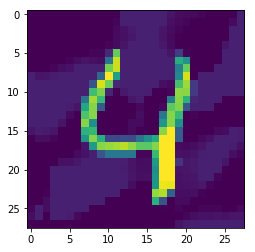

In [29]:
plt.imshow(adversaries[4]['adversary'].reshape(28,28))

In [30]:
adv_df['prediction'].value_counts()/adv_df.shape[0]

2    0.179
3    0.172
5    0.159
8    0.133
9    0.112
7    0.078
4    0.061
6    0.056
0    0.031
1    0.019
Name: prediction, dtype: float64

In [31]:
adv_df[adv_df['class'] == adv_preds]['prediction'].value_counts()/adv_df[adv_df['class'] == adv_preds]['prediction'].shape[0]

3    0.179856
2    0.176259
5    0.167866
8    0.127098
9    0.099520
7    0.080336
4    0.061151
6    0.057554
0    0.029976
1    0.020384
Name: prediction, dtype: float64

In [ ]:
colors = ['black', 'blue', 'red', 'green', 'yellow', 'orange', 'purple', 'pink', 'silver', 'cyan']
labels = list(range(10))

In [ ]:
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import PyQt5

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)

# plt.cla()
# pca = PCA(n_components=3)
# pca.fit(X)
# X_pca = pca.transform(X)

# for i in range(len(X_pca)):
#     ax.scatter(X_pca[i,0], X_pca[i,1], X_pca[i,2], color=colors[res_df['prediction'].iloc[i]])

In [ ]:
# from sklearn import manifold
# from collections import OrderedDict

# fig = plt.figure(1, figsize=(4, 3))
# plt.clf()
# ax = Axes3D(fig)
# plt.cla()

# # X_dimmed = manifold.TSNE(n_components=3, init='pca', random_state=0).fit_transform(X)
# X_dimmed = manifold.Isomap(10, 3).fit_transform(X)

# for i in range(len(X_dimmed)):
#     ax.scatter(X_dimmed[i,0], X_dimmed[i,1], X_dimmed[i,2], color=colors[res_df['class'].iloc[i]], label=labels[res_df['class'].iloc[i]])

# handles, labs = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labs, handles))
# ax.legend(by_label.values(), by_label.keys())

In [ ]:
from sklearn.decomposition import PCA
from sklearn import manifold
from collections import OrderedDict
plot_take = 1000

In [ ]:
fig, ax = plt.subplots()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

for i in range(len(X_pca)):
    ax.scatter(X_pca[i,0], X_pca[i,1], color=colors[res_df['prediction'].iloc[i]], label=labels[res_df['class'].iloc[i]])
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())

In [ ]:
from sklearn import manifold
fig, ax = plt.subplots()
X_dimmed = manifold.Isomap(n_neighbors=15, n_components=2).fit_transform(X)
# X_dimmed = manifold.TSNE(n_components=2, init='pca', random_state=5).fit_transform(X)
# X_dimmed = manifold.SpectralEmbedding(n_neighbors=100, n_components=2).fit_transform(X)
# X_dimmed = manifold.MDS(2, max_iter=200, n_init=10).fit_transform(X)
# X_dimmed = manifold.LocallyLinearEmbedding(10, 2, eigen_solver='auto', method='standard').fit_transform(X)


for i in range(len(X_dimmed)):
    ax.scatter(X_dimmed[i,0], X_dimmed[i,1], color=colors[res_df['prediction'].iloc[i]], label=labels[res_df['prediction'].iloc[i]])
handles, labs = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labs, handles))
ax.legend(by_label.values(), by_label.keys())